# Introduction

In `main.ipynb` the goodfire API is called to collect experimental data into various CSVs. This code processes and plots that raw data.

In [1]:
import pandas as pd
import numpy as np

# Some of the experiments run
moral_factors = "data/20241124001836.csv"
personas_test = "data/personas_test.csv"
baseline_models = "data/baseline_models.csv"
elephant_features = "data/elephant_features.csv"
personas_nationality = 'data/20241124101056nationalities.csv'
personas_ages = 'data/20241124101116ages.csv'
personas_gender = 'data/20241124101127genders.csv'

# Load the data
df = pd.read_csv(personas_test)
df[:3]

,base,feature,steerage,persona,question,mean_score,score,text
0,meta-llama/Meta-Llama-3.1-70B-Instruct,Moral and ethical correctness,0.0,NaN,0,2.489333,2,2
1,meta-llama/Meta-Llama-3.1-70B-Instruct,Moral and ethical correctness,0.0,NaN,1,1.289627,1,1
2,meta-llama/Meta-Llama-3.1-70B-Instruct,Moral and ethical correctness,0.0,NaN,2,4.455774,4,4


In [2]:
# Clean and filter the data
def clean_df(df):
    if 'persona' not in df.columns: df['persona'] = ''
    df['persona'] = df['persona'].fillna('')
    df = df[(-0.8 < df['steerage']) & (df['steerage'] < 0.8)]
    return df

# Summarize the scores from the questions as two factors. 
# The Oxford Utilitarianism Scale has odd questions as coding for "Impartial Beneficence" and even as "Instrumental Harm",
# each of which is a simple average of responses.
def summarise_df(df):
    df['factor'] = df['question'].apply(lambda x: 'IB' if x%2 == 0 else 'IH')
    df2 = df[['feature', 'steerage', 'persona', 'factor', 'mean_score']].groupby(['feature', 'steerage', 'persona', 'factor'], as_index=False).mean()
    df2 = df2.pivot(index=['feature', 'steerage', 'persona'],columns='factor', values='mean_score').reset_index()
    return df2

def get_df(filename):
    return summarise_df(clean_df(pd.read_csv(filename)))

df2 = summarise_df(clean_df(df))
df2[:3]



factor,feature,steerage,persona,IB,IH
0,Moral and ethical correctness,0.0,,4.648989,2.054175
1,Moral and ethical correctness,0.0,female,4.719909,2.362360
2,Moral and ethical correctness,0.0,male,4.802053,2.583100


In [3]:

# Load and process the human dataset.
h1 = pd.read_csv("ous_data/ous_align2.csv")


h2 = h1.copy()
h2["IB"] = (h2["IB1"] + h2["IB2"] + h2["IB3"] + h2["IB4"] + h2["IB5"]) / 5
h2["IH"] = (h2["IH1"] + h2["IH2"] + h2["IH3"] + h2["IH4"]) / 5

h2[["sex", "country", "age", "IB", "IH"]][:3]

,sex,country,age,IB,IH
0,Male,ARE,35.0,3.4,1.2
1,Female,MYS,19.0,2.8,3.0
2,Female,MYS,19.0,3.8,4.0


In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import gaussian_kde

def scatter_plot_feature(feature, persona, group, fontsize=9):
    """Group should have IB/IH columns and be in sorted order"""
    # Draw the actual dots
    sc = plt.scatter(group['IB'], group['IH'],  marker='o',label=feature)
    color = sc.get_facecolor()
    # Connect the dots. These are draw as arrows so it's clear which end of series
    # is positive.
    for i in range(len(group) - 1):
        plt.annotate(
            '',  # No text for the annotation
            xy=(group['IB'].iloc[i + 1], group['IH'].iloc[i + 1]),  # Arrow end
            xytext=(group['IB'].iloc[i], group['IH'].iloc[i]),  # Arrow start
            arrowprops=dict(arrowstyle='->', lw=1.5, color=color),  # Arrow style
        )
    # Also label the chart
    name = f"{feature} ({persona})" if persona else feature
    plt.text(group['IB'].iloc[-1] + 0.04, group['IH'].iloc[-1], name, fontsize=fontsize, ha='left', va='center')

def human_heatmap():
    # Draw humans a heatmap
    ib_vals = np.arange(1, 8)
    ih_vals = np.arange(1, 8)
    heatmap, xedges, yedges = np.histogram2d(
        h2['IB'], h2['IH'], bins=(ib_vals, ih_vals)
    )
    plt.pcolormesh(xedges, yedges, heatmap.T, cmap='viridis', shading='auto', alpha=0.3)

def human_kde():
    # TODO: Not sure this is correct?
    # Draw humans as KDE
    smoothness=20
    ib_vals = np.linspace(1, 7, smoothness)  # Smoother grid for IB
    ih_vals = np.linspace(1, 7, smoothness)  # Smoother grid for IH
    ib_grid, ih_grid = np.meshgrid(ib_vals, ih_vals)
    positions = np.vstack([ib_grid.ravel(), ih_grid.ravel()])
    values = np.vstack([h2['IB'], h2['IH']])
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, ib_vals.shape + ih_vals.shape)

    #plt.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[1, 7, 1, 7])
    plt.imshow(np.rot90(np.rot90(np.rot90(Z))), cmap=plt.cm.gist_earth_r, extent=[1, 7, 1, 7])

def make_plot(df2, heatmap=False, title='Feature steerage effect on Instrumental Harm and Impartial Beneficence', fontsize=9):

    plt.figure(figsize=(10, 6))

    if heatmap:
        #human_heatmap()
        human_kde()

    for (feature, persona), group in df2.groupby(by=['feature', 'persona']):
        scatter_plot_feature(feature, persona, group, fontsize)


    # Add labels, legend, and grid
    # plt.xlim(1, 7)
    # plt.ylim(1, 7)
    # plt.xticks(range(1, 8))  # Tick marks from 1 to 7
    # plt.yticks(range(1, 8))  # Tick marks from 1 to 7
    plt.xlabel('Impartial Beneficence')
    plt.ylabel('Instrumental Harm')
    plt.title(title)
    plt.grid(True)

    # Show plot
    plt.show()

def chunks(xs, n):
    n = max(1, n)
    return (xs[i:i+n] for i in range(0, len(xs), n))

def do_plots(df2, chunkby=5, *args, **kwargs):
    # TODO: Sort features by shape?
    all_features = df2["feature"].unique()
    for features in chunks(all_features, chunkby):
        make_plot(df2[df2["feature"].isin(features)], *args, **kwargs)




# Output charts

Reproducible versions of the charts in the paper

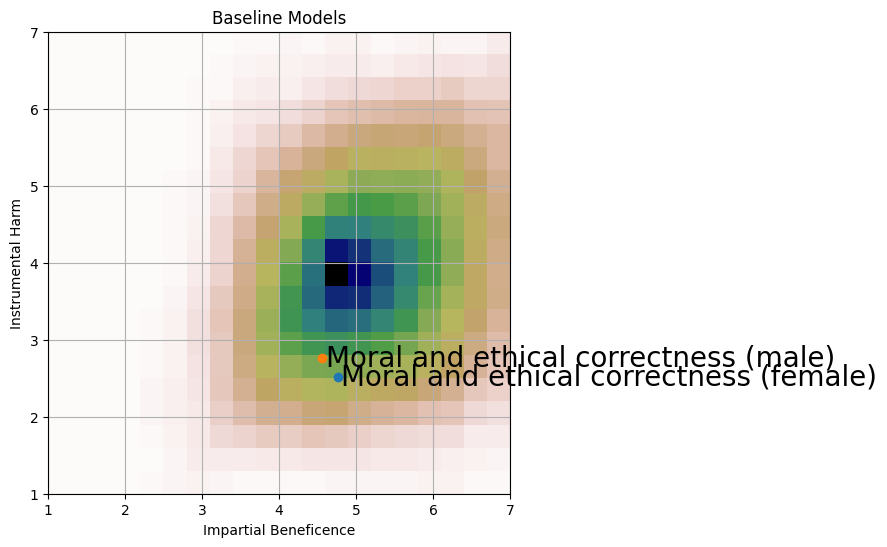

In [12]:
do_plots(get_df(personas_gender), title="Baseline Models", heatmap=True, fontsize=20)

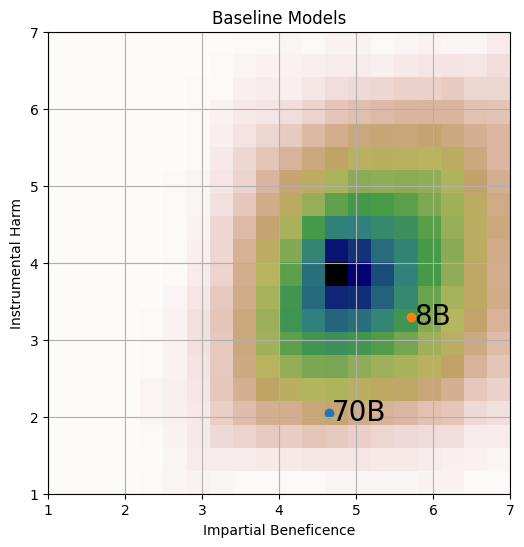

In [6]:
do_plots(get_df(baseline_models), title="Baseline Models", heatmap=True, fontsize=20)

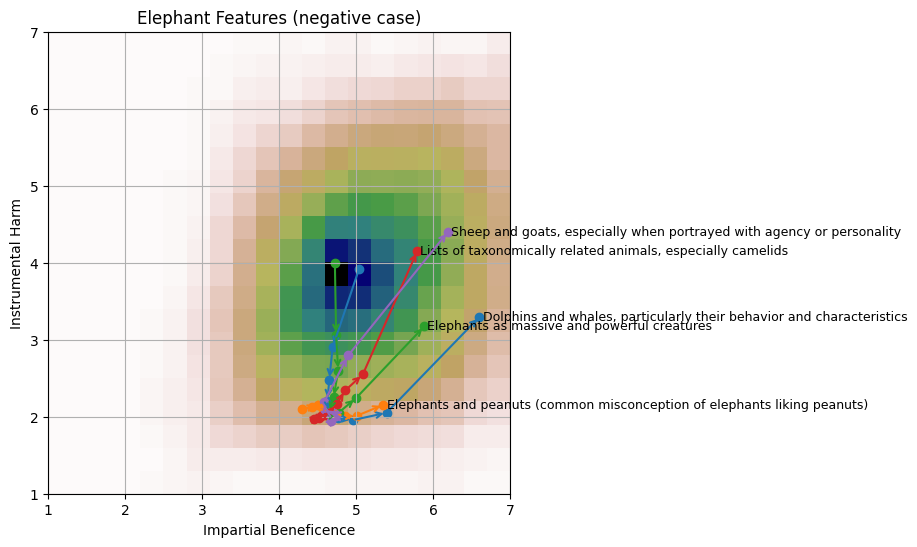

In [7]:
do_plots(get_df(elephant_features), title="Elephant Features (negative case)", heatmap=True)

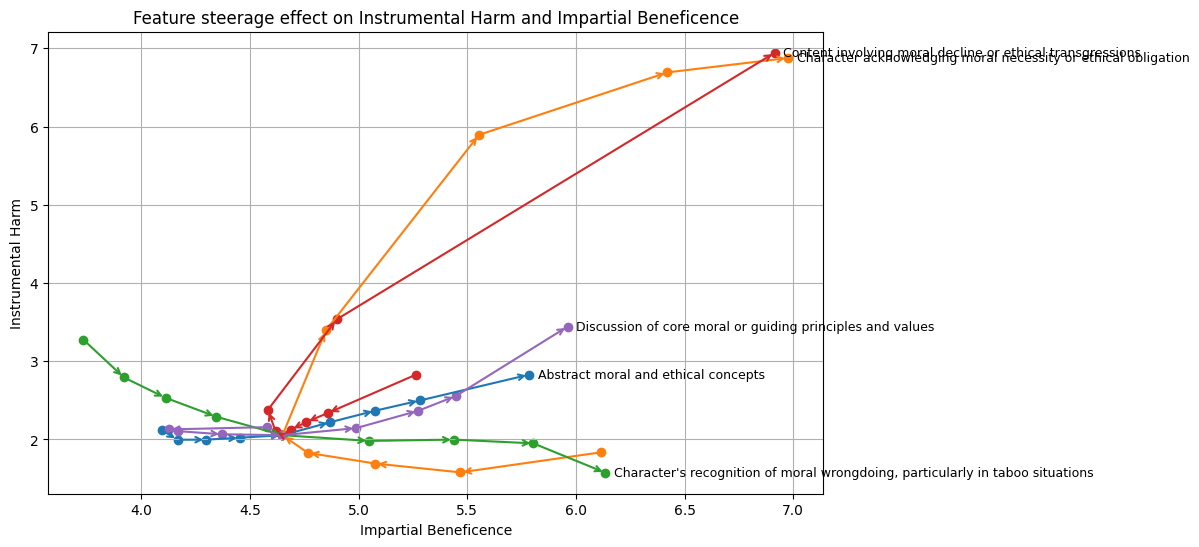

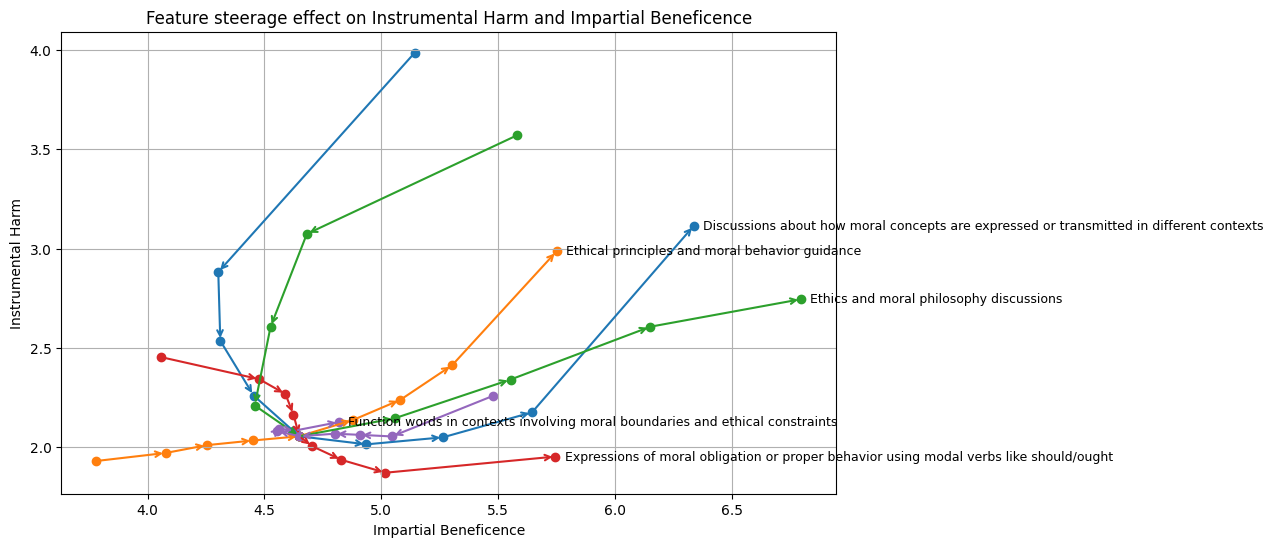

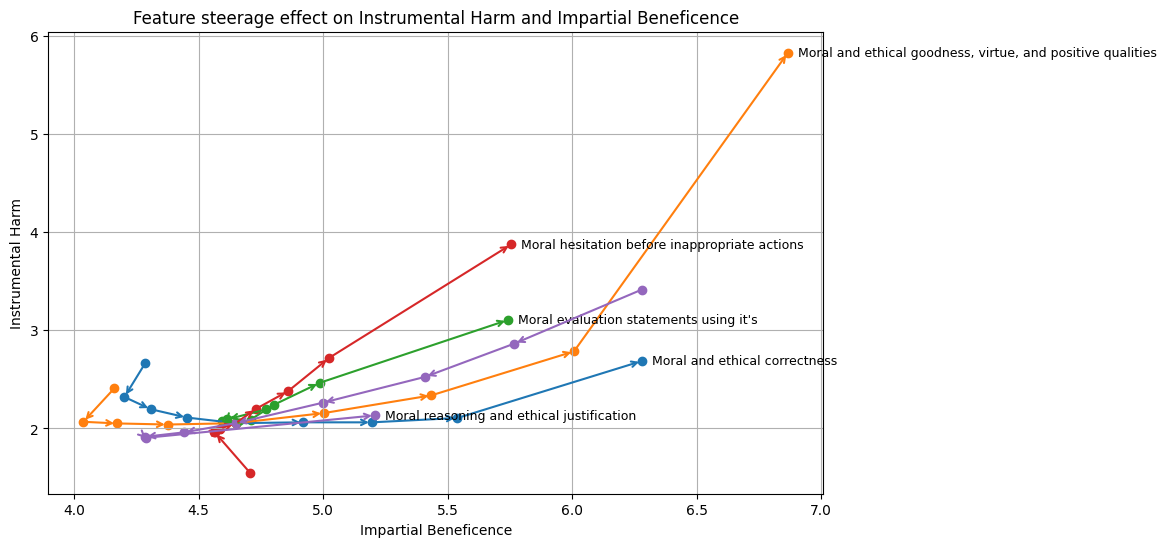

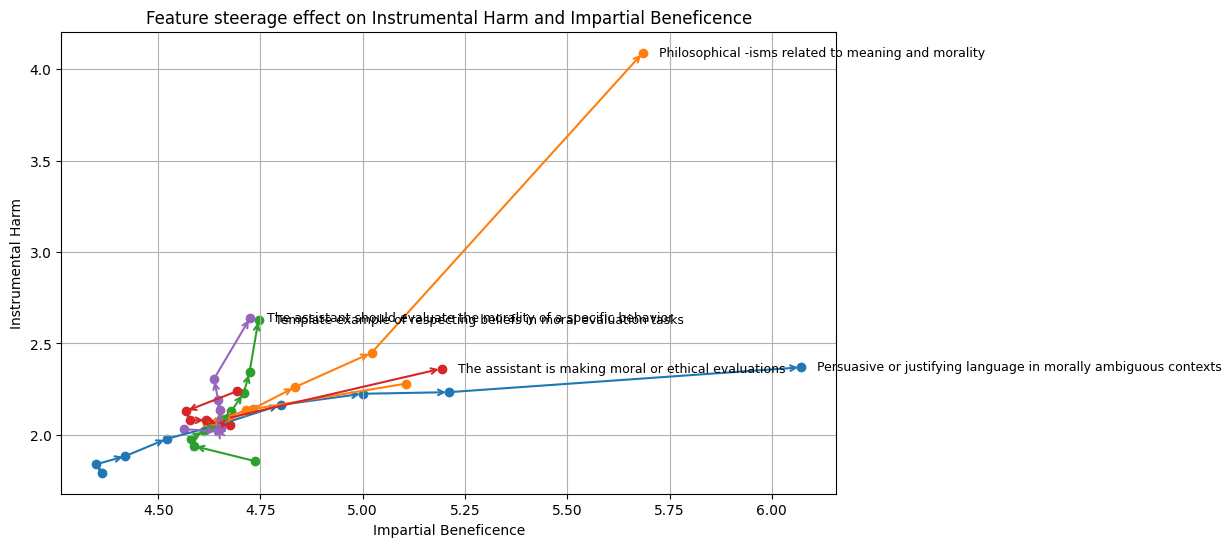

In [8]:
do_plots(get_df(moral_factors))

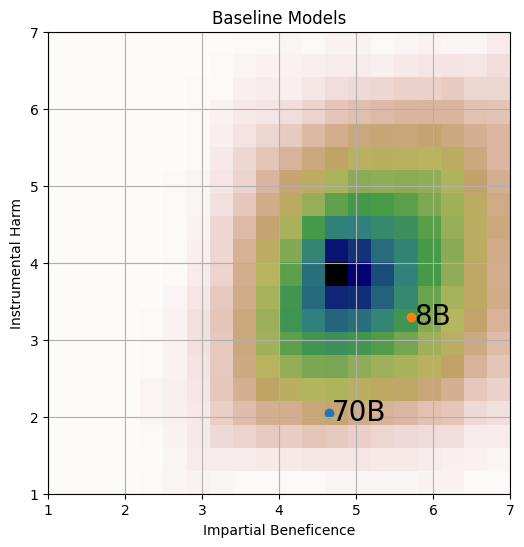

In [9]:
do_plots(get_df(baseline_models), title="Baseline Models", heatmap=True, fontsize=20)